In [1]:
from lightning import Trainer
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset
from MLPW.data.manifold import SwissRoll_DataModule
import torch


train_loader = SwissRoll_DataModule().get_train_loader()



In [2]:
def noiser(x0):
    eps = torch.randn_like(x0[0])
    t = torch.rand((x0[0].shape[0],1)).to(x0[0].device)
    xt = torch.cos(torch.pi/2 *t)*x0[0] + torch.sin(torch.pi/2 *t)*eps
    return eps, t, xt

all_samples = []
for x0 in train_loader:
    eps, t, xt = noiser(x0)
    all_samples.append((x0, eps, t, xt))


In [3]:
print(all_samples[0][0])

[tensor([[ -3.7587,  -9.5181],
        [ -0.7224,   8.4600],
        [ -3.9437, -10.4135],
        ...,
        [  2.9890,   7.3258],
        [  0.6817,   8.1212],
        [ -0.0490,   7.1720]])]


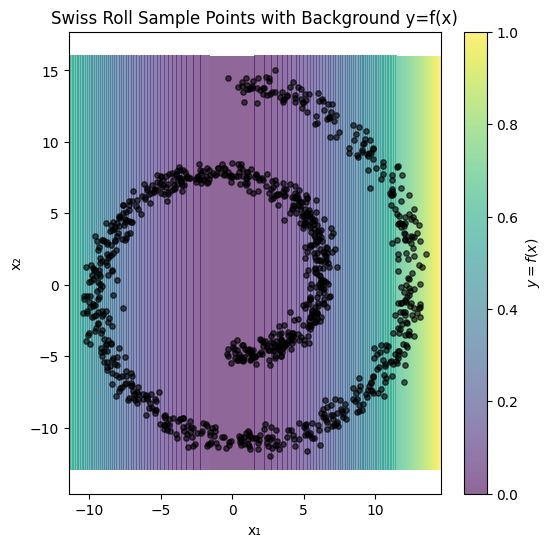

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 示例：假设你已经有 sample 点 all_samples 了
x_data = all_samples[0][0][0][:, 0]
y_data = all_samples[0][0][0][:, 1]

# 构建网格，用来绘制背景的 f(x)
x_min, x_max = x_data.min() - 1, x_data.max() + 1
y_min, y_max = y_data.min() - 1, y_data.max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# 定义你的函数 f(x, y)，例如一个简单的例子
# 可以替换成你真实的 f，例如瑞士卷上的位置、或者从原始数据中的 y 值插值得到
def f(x, y):
    return 0.1 * (x**2)  # 举个例子

zz = f(xx, yy)

# 开始画图
plt.figure(figsize=(6, 6))

# 画背景的颜色图
plt.contourf(xx, yy, zz, levels=100, cmap='viridis', alpha=0.6)

# 画你的数据点
plt.scatter(x_data, y_data, s=15, alpha=0.6, c='black')

plt.colorbar(label='$y = f(x)$')
plt.title("Swiss Roll Sample Points with Background y=f(x)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.axis("equal")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.tight_layout()
plt.show()

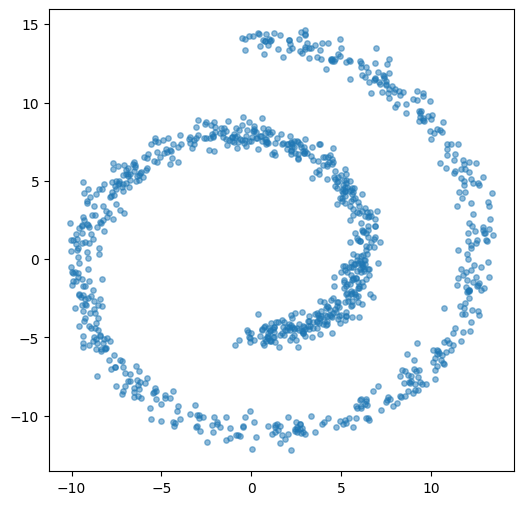

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6, 6])
plt.scatter(all_samples[0][0][0][:,0],all_samples[0][0][0][:,1],s=15,alpha=0.5)
#plt.axis('off')
plt.show()
plt.close()

In [3]:
from MLPW.arc.ddpm import DDPM

device = torch.device("cpu")
model = DDPM().to(device)
# 创建训练器并训练模型
trainer = Trainer(max_epochs=100)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
trainer.fit(model, train_loader)


  | Name    | Type | Params | Mode 
-----------------------------------------
0 | decoder | MLP  | 28.0 K | train
-----------------------------------------
28.0 K    Trainable params
0         Non-trainable params
28.0 K    Total params
0.112     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/jiayi/.local/share/virtualenvs/MLPW-mOq2XAYX/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 98/98 [00:00<00:00, 172.41it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 98/98 [00:00<00:00, 170.72it/s, v_num=4]


In [5]:
model.to('cpu')

DDPM(
  (decoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=164, bias=True)
      (1): ReLU()
      (2): Linear(in_features=164, out_features=164, bias=True)
      (3): ReLU()
      (4): Linear(in_features=164, out_features=2, bias=True)
    )
  )
)

In [7]:
import numpy as np
from tqdm import tqdm
num_steps = 1024
ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1) # from noise(t~1) to initial image(t~0)
xt = torch.randn(2000, 2) # start from time t, recond result from 1 st step of diffusion (that is time )
all_samples = []
def is_power_of_4(i):
    return (i > 0) and (i & (i - 1)) == 0 and (i % 3 == 1)

for i in tqdm(range(num_steps), desc="Processing"):
      t = torch.full((2000, 1), ts[i])
      tm1 = torch.full((2000, 1), ts[i+1])
      noise_pred = model.decoder(torch.cat((xt, t),dim=1))
      #print(xt[0], noise_pred[0])
      alpha_t = torch.cos(torch.pi/2 * t)**2/torch.cos(torch.pi/2 * tm1)**2
      mu_hat_t = (xt - (1-alpha_t)/torch.sin(torch.pi/2 * t)*noise_pred)/alpha_t.sqrt()
      z = torch.randn_like(xt)
      sigma = (1.-alpha_t).sqrt()
      xt = mu_hat_t + sigma*z
      if i==15 or i==63 or i==255 or i==511 or i==1023:
        all_samples.append(xt.detach().numpy())


Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1330.31it/s]


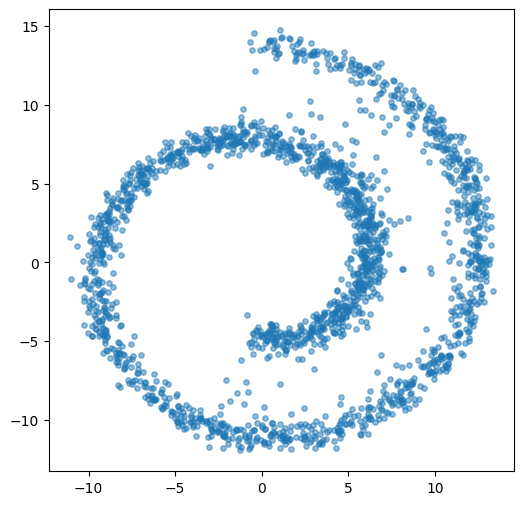

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6, 6])
plt.scatter(all_samples[-1][:,0],all_samples[-1][:,1],s=15,alpha=0.5)
#plt.axis('off')
plt.show()
plt.close()
# TODO: solve 异常离群点问题，和设备有关吗？

In [ ]:
# 训练黑盒子做的事情

epochs = 100
for epoch in range(epochs):
  for x in train_loader:
    x = x.to(device)
    model.optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    model.optimizer.step()
  print(f"Epoch {epoch} loss: {loss.item()}")

In [3]:
# 如果还想看模型内部...
from MLPW.arc.ddpm import noiser
from MLPW.arc.utils.mlp import MLP
import torch.nn as nn
import torch
from MLPW.data.manifold import SwissRoll_DataModule


din = 3
dout = 2
epochs = 100
train_loader = SwissRoll_DataModule().get_train_loader()
model_white = MLP(din, dout)
optimizer = torch.optim.Adam(model_white.parameters(), lr=1e-3)
model_white.train()
for epoch in range(epochs):
  for x in train_loader:
    optimizer.zero_grad()
    eps, t, xt = noiser(x) # batch is x0, clean input
    eps_hat = model_white(torch.cat((xt, t), dim=1))
    loss = nn.functional.mse_loss(eps, eps_hat)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch} loss: {loss.item()}")
model_white.eval()

Epoch 0 loss: 0.9783425331115723
Epoch 1 loss: 0.8779825568199158
Epoch 2 loss: 0.9116454124450684
Epoch 3 loss: 0.8538133502006531
Epoch 4 loss: 0.9078495502471924
Epoch 5 loss: 0.8240105509757996
Epoch 6 loss: 0.8497802019119263
Epoch 7 loss: 0.7980300188064575
Epoch 8 loss: 0.8170410990715027
Epoch 9 loss: 0.8297594785690308
Epoch 10 loss: 0.8035694360733032
Epoch 11 loss: 0.8518439531326294
Epoch 12 loss: 0.7578139901161194
Epoch 13 loss: 0.8418707251548767
Epoch 14 loss: 0.7769310474395752
Epoch 15 loss: 0.7513391375541687
Epoch 16 loss: 0.7727276682853699
Epoch 17 loss: 0.7923256158828735
Epoch 18 loss: 0.774522066116333
Epoch 19 loss: 0.7811837196350098
Epoch 20 loss: 0.7614525556564331
Epoch 21 loss: 0.7607724666595459
Epoch 22 loss: 0.7572660446166992
Epoch 23 loss: 0.727306067943573
Epoch 24 loss: 0.7769530415534973
Epoch 25 loss: 0.7171708941459656
Epoch 26 loss: 0.737555980682373
Epoch 27 loss: 0.7361297011375427
Epoch 28 loss: 0.7382891774177551
Epoch 29 loss: 0.7267279624

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=164, bias=True)
    (1): ReLU()
    (2): Linear(in_features=164, out_features=164, bias=True)
    (3): ReLU()
    (4): Linear(in_features=164, out_features=2, bias=True)
  )
)

In [5]:
import numpy as np
from tqdm import tqdm
num_steps = 1024
ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1) # from noise(t~1) to initial image(t~0)
xt = torch.randn(2000, 2) # start from time t, recond result from 1 st step of diffusion (that is time )
all_samples = []
def is_power_of_4(i):
    return (i > 0) and (i & (i - 1)) == 0 and (i % 3 == 1)

for i in tqdm(range(num_steps), desc="Processing"):
      t = torch.full((2000, 1), ts[i])
      tm1 = torch.full((2000, 1), ts[i+1])
      noise_pred = model_white(torch.cat((xt, t),dim=1))
      #print(xt[0], noise_pred[0])
      alpha_t = torch.cos(torch.pi/2 * t)**2/torch.cos(torch.pi/2 * tm1)**2
      mu_hat_t = (xt - (1-alpha_t)/torch.sin(torch.pi/2 * t)*noise_pred)/alpha_t.sqrt()
      z = torch.randn_like(xt)
      sigma = (1.-alpha_t).sqrt()
      xt = mu_hat_t + sigma*z
      if i==15 or i==63 or i==255 or i==511 or i==1023:
        all_samples.append(xt.detach().numpy())


Processing: 100%|██████████| 1024/1024 [00:00<00:00, 1239.63it/s]


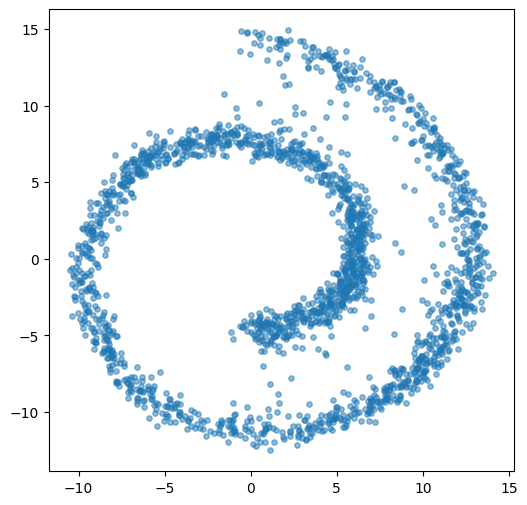

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6, 6])
plt.scatter(all_samples[-1][:,0],all_samples[-1][:,1],s=15,alpha=0.5)
#plt.axis('off')
plt.show()
plt.close()
# TODO: solve 异常离群点问题，和设备有关吗？